# Getting started with CVXPY
The following is adapted from https://www.cvxpy.org/tutorial/intro/index.html. 

The code below solves a simple optimization problem in CVXPY.  First, we import the cvxpy module:

In [1]:
import cvxpy as cp

Next we create two scalar optimization variables $x$ and $y$ by calling ```cp.Variable()```

In [2]:
# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

Now that we have optimization variables, we can add constraints.  CVXPY allows you to write constraints as you would naturally in an optimization problem, and store them in an array.

In [3]:
# Create two constraints.
constraints = [x + y == 1,
               x - y >= 1]

Similarly, we can define an objective function.  We can either minimize or maximize an expression defined in terms of the optimization variables by calling ```cp.Minimize(f(x))``` or ```cp.Maximize(f(x))```

In [4]:
# Form objective.
obj = cp.Minimize((x - y)**2)

Now that we have variables, constraints, and an objective, it is time to form the problem, and solve it.  To do so, we call ```cp.Problem(obj,constraints)``` to form the problem, and then ```prob.solve()``` to actually solve it.  The status of the problem is stored in ```prob.status```, which will be _optimal_ if the problem was solved successfully, _infeasible_ if the problem is infeasible, _unbounded_ if the problem is unbounded, or _inaccurate_ if numerical issues were encountered.  The optimal value can be obtained by querying ```prob.value``` and the optimal values of $x$ and $y$ by querying ```x.value``` and ```y.value``` respectively.

In [5]:
# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var x: {}, optimal var y: {}".format(x.value, y.value))

status: optimal
optimal value 1.0
optimal var x: 1.0, optimal var y: 1.570086213240983e-22


The status, which was assigned a value “optimal” by the solve method, tells us the problem was solved successfully. The optimal value (basically 1 here) is the minimum value of the objective over all choices of variables that satisfy the constraints. The last thing printed gives values of $x$ and $y$ (basically 1 and 0 respectively) that achieve the optimal objective.

# Changing the problem

*Problems* are immutable, meaning they cannot be changed after they are created.  To change the objective or constraints, create a new problem.

In [6]:
# Replace the objective.
prob2 = cp.Problem(cp.Maximize(x + y), prob.constraints)
print("optimal value", prob2.solve())

optimal value 1.0000000017629223


In [7]:
# Replace the constraint (x + y == 1).
constraints = [x + y <= 3] + prob2.constraints[1:]
prob3 = cp.Problem(prob2.objective, constraints)
print("optimal value", prob3.solve())

optimal value 2.9999999970750015


# Infeasible and unbounded problems

If a problem is infeasible or unbounded, the status field will be set to “infeasible” or “unbounded”, respectively. The value fields of the problem variables are not updated.

In [8]:
x = cp.Variable()

# An infeasible problem.
prob = cp.Problem(cp.Minimize(x), [x >= 1, x <= 0])
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

status: infeasible
optimal value inf


In [9]:
# An unbounded problem.
prob = cp.Problem(cp.Minimize(x))
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

status: unbounded
optimal value -inf


Notice that for a minimization problem the optimal value is ```inf``` if infeasible and ```-inf``` if unbounded. For maximization problems the opposite is true.

# Other problem statuses

If the solver called by CVXPY solves the problem but to a lower accuracy than desired, the problem status indicates the lower accuracy achieved. The statuses indicating lower accuracy are

- “optimal_inaccurate”

- “unbounded_inaccurate”

- “infeasible_inaccurate”

The problem variables are updated as usual for the type of solution found (i.e., optimal, unbounded, or infeasible).

If the solver completely fails to solve the problem, CVXPY throws a ```SolverError``` exception. If this happens you should try using other solvers. See the discussion of [Choosing a solver for details](https://www.cvxpy.org/tutorial/advanced/index.html#solvers).

CVXPY provides the following constants as aliases for the different status strings:

- ```OPTIMAL```
- ```INFEASIBLE```
- ```UNBOUNDED```
- ```OPTIMAL_INACCURATE```
- ```INFEASIBLE_INACCURATE```
- ```UNBOUNDED_INACCURATE```

For example, to test if a problem was solved successfully, you would use

```prob.status == OPTIMAL```

# Vectors and matrices

*Variables* can be scalars, vectors, or matrices, meaning they are 0, 1, or 2 dimensional.

In [10]:
# A scalar variable.
a = cp.Variable()

# Vector variable with shape (5,).
x = cp.Variable(5)

# Matrix variable with shape (5, 1).
x = cp.Variable((5, 1))

# Matrix variable with shape (4, 7).
A = cp.Variable((4, 7))

You can use your numeric library of choice to construct matrix and vector constants. For instance, if ```x``` is a CVXPY Variable in the expression ```A @ x + b```, ```A``` and ```b``` could be Numpy ndarrays, SciPy sparse matrices, etc. ```A``` and ```b``` could even be different types.

Currently the following types may be used as constants:

- NumPy ndarrays 
- NumPy matrices
- SciPy sparse matrices

Here’s an example of a CVXPY problem with vectors and matrices to solve a bounded least-squares problem using NumPy:

In [11]:
# import modules
import cvxpy as cp
import numpy as np

In [12]:
# setup problem data

# set up matrix dimensions: A \in R^{m by n}, b \in R^m
m = 10
n = 5

# fix random seed for reproducibility
np.random.seed(1)

# generate problem data
A = np.random.randn(m,n)
b = np.random.randn(m)

In [13]:
# construct the problem

# declare optimization variable x \in R^n
x = cp.Variable(n)

# setup least-squares objective
objective = cp.Minimize(cp.sum_squares(A @ x - b)) 
# note for those new to python that A @ x = A.dot(x) = matrix-vector multiplication

# setup constraints, 0 <= x <= 1
constraints = [0<=x, x<= 1]

# build the problem
problem = cp.Problem(objective, constraints)

# solve the problem and print out the results

print("Optimal value: {}".format(problem.solve()))
print("Optimal variable x: {}".format(x.value)) # A NumPy ndarray

Optimal value: 4.141338603672535
Optimal variable x: [-4.95922264e-21  6.07571976e-21  1.34643668e-01  1.24976681e-01
 -4.57130806e-21]


# Constraints

As shown in the example code, you can use ```==```, ```<=```, and ```>=``` to construct constraints in CVXPY. Equality and inequality constraints are elementwise, whether they involve scalars, vectors, or matrices. For example, together the constraints ```0 <= x``` and ```x <= 1``` mean that every entry of ```x``` is between 0 and 1.

If you want matrix inequalities that represent semi-definite cone constraints, see [Semidefinite matrices](https://www.cvxpy.org/tutorial/advanced/index.html#semidefinite). The section explains how to express a semi-definite cone inequality.

You cannot construct inequalities with ```<``` and ```>```. Strict inequalities don’t make sense in a real world setting. Also, you cannot chain constraints together, e.g., ```0 <= x <= 1``` or ```x == y == 2```. The Python interpreter treats chained constraints in such a way that CVXPY cannot capture them. CVXPY will raise an exception if you write a chained constraint.

# Parameters

*Parameters* are symbolic representations of constants. The purpose of parameters is to change the value of a constant in a problem without reconstructing the entire problem. In many cases, solving a parametrized program multiple times can be substantially faster than repeatedly solving a new problem (see [Disciplined Parametrized Programming](https://www.cvxpy.org/tutorial/advanced/index.html#dpp)).

Parameters can be vectors or matrices, just like variables. When you create a parameter you have the option of specifying attributes such as the sign of the parameter’s entries, whether the parameter is symmetric, etc. These attributes are used in [Disciplined Convex Programming](https://www.cvxpy.org/tutorial/dcp/index.html#dcp) and are unknown unless specified. Parameters can be assigned a constant value any time after they are created. The constant value must have the same dimensions and attributes as those specified when the parameter was created.

In [14]:
# Positive scalar parameter.
m = cp.Parameter(nonneg=True)
print("unassigned parameter m: {}".format(m.value))

unassigned parameter m: None


In [15]:
# Column vector parameter with unknown sign (by default).
c = cp.Parameter(5)
print("unassigned parameter c: {}".format(c.value))

unassigned parameter c: None


In [16]:
# Matrix parameter with negative entries.
G = cp.Parameter((4, 7), nonpos=True)
print("unassigned parameter G: {}".format(G.value))

unassigned parameter G: None


In [17]:
# Assigns a constant value to G.
G.value = -np.ones((4, 7))
print("assigned parameter G: \n {}".format(G.value))

assigned parameter G: 
 [[-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.]]


You can initialize a parameter with a value. The following code segments are equivalent:

In [18]:
# Create parameter, then assign value.
rho = cp.Parameter(nonneg=True)
rho.value = 2
print("rho assigned value of: {}".format(rho.value))

rho assigned value of: 2


In [19]:
# Initialize parameter with a value.
rho = cp.Parameter(nonneg=True, value=2)
print("rho assigned value of: {}".format(rho.value))

rho assigned value of: 2


# Computing trade-off curves

Computing trade-off curves is a common use of parameters.  The example below computes a trade-off curve for a LASSO problem.  The LASSO problem seeks to find sparse solutions to an under-determined least-squares problem by adding an $\ell_1$-regularizer to the problem.  The $\ell_1$-norm can be viewed as the tightest convex relaxation of the so-called $\ell_0$-"norm", which counts the nonzero elements of a vector $x$, which is neither a norm, nor is it convex.

For more information on the LASSO problem (which we will see more of later in the class), the following are good references:

- [Regression Shrinkage and Selection via the Lasso](https://rss.onlinelibrary.wiley.com/doi/pdf/10.1111/j.2517-6161.1996.tb02080.x?casa_token=wM09Jx4u7X4AAAAA%3AkyRemlYlomipEuCWiV5cJ25EwSfnXgso0Le-j3yw2F1mLXhNBDGolKQ1ZaqKbqpriIzzpMaxBoRT1QGi), R. Tibshirani, 1996.
- [For Most Large Underdetermined Systems of Equations, the Minimal $\ell_1$-norm Near-Solution Approximates the Sparsest Near-Solution](https://onlinelibrary.wiley.com/doi/pdf/10.1002/cpa.20131?casa_token=p7m9o64qjooAAAAA:TenBYUBnKREPBiQJr-H5AjiXXgHaOpwMpbZDfW54V9UmM5Wf3okWAEtPCu9SoW0Y9JX8koK8sYifs-Mq), D. Donoho, 2006.
- [The Convex Geometry of Linear Inverse Problems](https://arxiv.org/abs/1012.0621), Chandrasekaran, Recht, Parrilo, and Willsky, 2012

In [7]:
# import modules
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt # Matlab like plotting functionality

In [8]:
# setup problem data

# an underdetermined problem with A \in R^{m by n}, b \in R^m
# with a k nonzero solution, i.e. Ax = b, with card(x) = k
m = 40
n = 100
k = 5

# set random seed for reproducibility
np.random.seed(1)
A = np.random.randn(m,n)

# pick 5 columns of A at random from which to construct the solution b
idx = np.sort(np.random.choice(100,5))
sparse_x = np.random.randn(5)
b = A[:,idx] @ sparse_x

print("The nonzero elements of x are {}".format(idx))
print("The values of these nonzero elements are {}".format(sparse_x))

# build the large full dimensional version of x for comparison later
nonsparse_x = np.zeros(n)
nonsparse_x[idx] = sparse_x

The nonzero elements of x are [21 34 44 59 93]
The values of these nonzero elements are [ 1.50440212  1.56026748  0.3849555  -0.3209712   0.31396613]


In [9]:
# Construct the problem

# setup the full (dense) optimization variable x \in R^n
x = cp.Variable(n)

# define the least-squares term of objective
least_squares = cp.sum_squares(A @ x - b)

# define the l1-regularizer in terms of a parameter gamma that 
# we will vary to generate our tradeoff curve
gamma = cp.Parameter(nonneg=True) # gamma >=0 to satisfy DCP rules
ell_one = cp.norm(x,1)

# define objective function as sum of least-squares and l1 regularizer
obj = cp.Minimize(least_squares + gamma*ell_one)

# build problem (no constraints here)
prob = cp.Problem(obj)

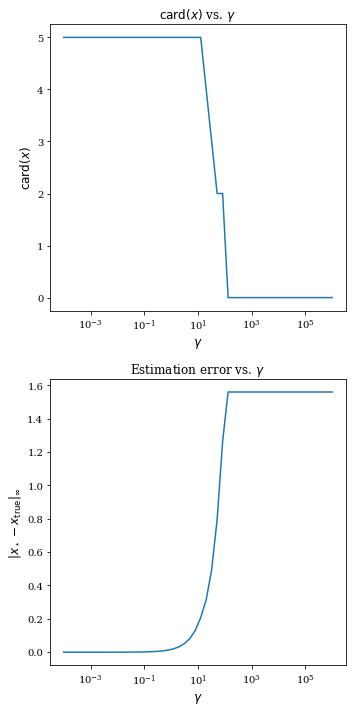

In [13]:
# Now we will loop over different gamma values to construct a tradeoff 
# curve

# create arrays for storing results
sq_penalty = [] # least-squares penalty
l1_penalty = [] # l1 penalty
x_nonzero = [] # nonzero terms
x_linf_error = [] # l-inf error of learned x

# create logarithimically spread out values of gamma to loop over
gamma_vals = np.logspace(-4,6)

# pythonically loop through gamma_vals
for val in gamma_vals:
    gamma.value = val
    prob.solve()
    # use expr.value to ge the numerical value of an expression
    # in the problem
    sq_penalty.append(least_squares.value)
    l1_penalty.append(ell_one.value)
    x_nonzero.append(np.count_nonzero(np.abs(x.value)>1e-4))
    x_linf_error.append(np.linalg.norm(x.value-nonsparse_x,np.inf))

# let's make some pictures now

#formatting
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.figure(figsize=(5,10))

# Plot # nonzero elements of x vs. gamma.
plt.subplot(211)
plt.plot(gamma_vals, x_nonzero)
plt.xlabel(r'$\gamma$', fontsize=12)
plt.ylabel(r'$\mathrm{card}(x)$', fontsize=12)
plt.xscale('log')
plt.title(r'$\mathrm{card}(x)$ vs. $\gamma$', fontsize=12)



# Plot l-inf error of x vs. gamma.
plt.subplot(212)
plt.plot(gamma_vals, x_linf_error)
plt.xlabel(r'$\gamma$', fontsize=12)
plt.ylabel(r'$\|x_\star - x_{\mathrm{true}}\|_\infty$', fontsize=12)
plt.xscale('log')
plt.title(r'Estimation error vs. $\gamma$', fontsize=12)

plt.tight_layout()
plt.show()


As you can see above, for $\gamma \in [10^-4,10^0]$, we recover the correct sparsity with $\mathrm{card}(x_\star)=5$ and $\|x_\star-x_{true}\}\|_\infty \approx 0$.  Then, for larger values, we are over penalizing sparsity, and get either an overly regularized value with correct sparity ($\gamma = 10^1$), or a too sparse value $\gamma \geq 10^2$.  In comparison, the least squares estimate does much worse!

In [6]:
# compute least squares solution
gamma.value = 0
prob.solve()

ls_linf_error = np.linalg.norm(x.value-nonsparse_x,np.inf)
ls_nonzero = np.count_nonzero(np.abs(x.value)>1e-4)
print("has {} nonzero entries and {} l-inf error".format(ls_nonzero,ls_linf_error))

Think about what you just did here! Using convex optimization, you solved a linear inverse problem in _one hundred_ variables given only _40_ measurements. Play around with the above to see how sparse you can make the solution relative to the number of measurements you have by suitably varying ```k``` and ```m```.  If you want to find out _why_ this works, I recommend digging into the papers linked above. 

# Why you should use Python instead of Matlab

Trade-off curves can easily be computed in parallel. The code below computes in parallel the optimal ```x``` for each ```𝛾``` in the LASSO problem above.

In [94]:
from multiprocessing import Pool
import time

# Assign a value to gamma and find the optimal x.
def get_x(gamma_value):
    gamma.value = gamma_value
    result = prob.solve()
    return x.value

# Parallel computation (set to 1 process here -- if you have multiple cores, try increasing by multiples of 2 and see how the elapsed time changes!).
pool = Pool(processes = 16)
start = time.time()
x_values = pool.map(get_x, gamma_vals)
print("elapsed time: {}".format(time.time()-start))

elapsed time: 0.11208891868591309
